<a href="https://colab.research.google.com/github/blufzzz/Introspective-Neural-Networks/blob/master/training_textures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [2]:
cd ./gdrive/My\ Drive/Colab Notebooks/Introspective-Neural-Networks-master

/content/gdrive/My Drive/Colab Notebooks/Introspective-Neural-Networks-master


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from torchvision.models import resnet18, vgg11
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
import os
import numpy as np
import PIL.Image as Image
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomResizedCrop, RandomCrop, RandomHorizontalFlip, ColorJitter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm import tnrange, tqdm_notebook
from IPython.core.debugger import set_trace
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

from utils import get_data_loaders, calculate_metric, print_scores

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
def train(model, train_loader, val_loader, epochs=1, batch_size = 20):

    start_ts = time.time()
    
    train_loader = DataLoader(train_loader, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_loader, batch_size = batch_size, shuffle = True)

    losses = []
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), amsgrad=True)

    batches = len(train_loader)
    val_batches = len(val_loader)

    # training loop + eval loop
    stopping_criteria = False
    epoch = 0
    while (not stopping_criteria):
        total_loss = 0
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
        model.train()

        for i, data in progress:
            X, y = data[0].cuda(), data[1].cuda().squeeze(-1) 
            
#             set_trace()
            
            model.zero_grad()
            outputs = model.forward(X)

            loss = loss_function(outputs, y)
            # pseudo - negative: y = 1
            # positive: y = 0
            

            loss.backward()
            optimizer.step()
            total_loss += loss.detach().item()
            progress.set_description("Loss: {:.4f}".format(loss.item()))

        torch.cuda.empty_cache()

        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].cuda(), data[1].cuda().squeeze(-1) 
                
                outputs = model.forward(X)
                
                loss = loss_function(outputs, y)
                val_losses += loss.detach().item()

                predicted_classes = torch.argmax(outputs, 1).detach()

                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, y.detach().cpu(), predicted_classes.cpu())
                    )

        
        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        losses.append(total_loss/batches)
        epoch += 1
        if sum(f1)/val_batches >= 0.99 or epoch > epochs:
            stopping_criteria = True
    pass

In [0]:
def plot_samples(dataset, t, l = 2, k = 2):
  
    fig, axes = plt.subplots(nrows = k, ncols = 2)
    fig.suptitle('Iteration {}'.format(t), fontsize=10, color = 'b')
    
    l_pos = len(texture_dataset.pos_imgs)
#     l_neg = len(texture_dataset.pseudo_neg_imgs)
    
    if k==1:
        axes = [axes]
    
    for ax, i_pos, i_neg  in zip(axes,
                                np.random.choice(range(l_pos), k, replace = False),
                                np.random.choice(range(1,l), k, replace = False)):
        
        im_pos = texture_dataset.pos_imgs[0]
        im_neg = texture_dataset.pseudo_neg_imgs[-i_neg]
        im_pos = im_pos.unsqueeze(0)
        im_neg = im_neg.unsqueeze(0)
        
        ax[0].imshow(deprocess(im_pos))
        ax[0].grid(False)
        ax[0].set_title('original')
        ax[1].imshow(deprocess(im_neg))
        ax[1].set_title('generated')
        ax[1].grid(False)
    
    plt.tight_layout()
    plt.savefig('./INN_texture_{}.jpg'.format(t))
    plt.show()

In [0]:
class TextureNet(nn.Module):
  
    def __init__(self, mean = 0, std = 1):
        super(TextureNet, self).__init__()
        
        self.cn1 = nn.Conv2d(3, 64, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(64)
        
        self.cn2 = nn.Conv2d(64,128, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(128)
        
        self.cn3 = nn.Conv2d(128,256, kernel_size=(5,5))
        self.bn3 = nn.BatchNorm2d(256)

        self.cn4 = nn.Conv2d(256,512, kernel_size=(5,5))
        self.bn5 = nn.BatchNorm2d(512)
        
        self.cn5 = nn.Conv2d(512,1, kernel_size=(1,1))
        
        self.activation = nn.LeakyReLU(0.2)
        
        self.fc = torch.nn.Linear(256, 2);
        self.mp = nn.MaxPool2d((2,2))
        self.softmax = nn.Softmax()
        
        self.X = torch.nn.Parameter(torch.empty((1, 3, 32, 32)).data.normal_(mean, std))
        self.X.requires_grad = False;
        
    def to_synth(self, x):
      
        x = self.cn1(x)
        
        x = self.cn2(x) 
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.cn3(x) 
        x = self.bn3(x)
        x = self.activation(x)
        
        x = self.cn4(x) 
        x = self.bn5(x)
        x = self.activation(x)
        
        x = self.cn5(x)
        x = self.activation(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
    
    def forward(self, x):
        return self.to_synth(x)
      
      

In [0]:
class Synthesis():
    def __init__(self, init_std=0.3):
        self.init_std = init_std;
        
    def sample(self, module, iter_max=100, learning_rate=0.1, noise = 0.1, threshold = 0.9, iter_min = 10, add_noise=True, reinitialize = False):
        assert isinstance(module.X, torch.nn.Parameter), 'Expected X to be an instance of torch.nn.Parameter';
        
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = False;
            else:
                param.requires_grad = True;
        
        if reinitialize:
            module.X.data = module.X.data.normal_(mean=0, std=self.init_std);
            
        opt = torch.optim.Adam([module.X], lr=learning_rate, amsgrad=True);
        std_noise = learning_rate;
        
        i = 0
        stopping_criteria = False
        while (not stopping_criteria):
            
            opt.zero_grad();
            
            logit = -module.to_synth(module.X)
            classes = logit[0,0];#torch.sum(torch.diag(logit))
            
            classes.backward();
                
            if add_noise:
                module.X.grad += torch.empty_like(module.X.data).normal_(mean=0, std=noise);

            prob = nn.Sigmoid()(-classes).item()
            
            stopping_criteria = (prob >= threshold)
            
            opt.step()
            
            # normalize
            module.X.data -= module.X.data.min()
            module.X.data /= module.X.data.max()            
            
            i += 1
            if i >= iter_max:
                print ('NOT CONV', prob, i)
                break
            
        module.train(True);
        for name, param in module.named_parameters():
            if name != 'X':
                param.requires_grad = True;
            else:
                param.requires_grad = False;
        
        return module.X.data;

In [0]:
class TextureDataset(torch.utils.data.Dataset):
  
      def __init__(self, root_dir = '../static_textures', texture_names = ['clover'], train_size = 1000, training=True):
          self.root_dir = root_dir
          self.train_size = train_size
          self.pos_imgs = [];
          self.labels = [];
          self.textures = []
          self.pseudo_neg_imgs = []
          self.transformation = Compose([RandomCrop((32, 32)), RandomHorizontalFlip(), ToTensor() ])
          
#           self.trans
          
          for texture_name in texture_names:
              path = os.path.join(root_dir, texture_name + '.jpg')
              img = Image.open(path)
              
              self.textures.append(img)
              
              for i in range(train_size):
                  
                  img_tensor = self.transformation(img)
                  self.pos_imgs.append(img_tensor.squeeze(0))
                  self.labels.append(torch.tensor([0]))

        
      def __getitem__(self, idx):
          
          self.imgs = self.pos_imgs + self.pseudo_neg_imgs
          x = self.imgs[idx];
          y = self.labels[idx];
        
          return x, y
        
      def __len__(self):
        
          return len(self.pos_imgs + self.pseudo_neg_imgs)
        
      def add_artificial(self, X):
          
          self.pseudo_neg_imgs.append(X.detach().cpu().squeeze(0));
          y = torch.tensor([1])
          self.labels.append(y);
        
        
def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)
    img = img.astype('float')

    return  img          

In [0]:
texture = 'stone'
texture_dataset = TextureDataset(texture_names = [texture], train_size = 2)

# all_tensors = torch.cat([texture_dataset[indx][0] for indx in range(100)])
# mean = all_tensors.mean().item()
# std = all_tensors.std().item()

model = TextureNet(mean, std).cuda()

# fig, axes = plt.subplots(ncols = 2, nrows=4, figsize = (10,10))
# for i,ax in enumerate(axes.flatten()):
    
#     im,y = texture_dataset[i]
#     im = im.unsqueeze(0)
#     img = deprocess(im)
#     ax.imshow(img)
#     ax.grid(False)

# # plt.savefig('./fig.png')
# plt.show()

Synthesizing...
texture_dataset_len =  12


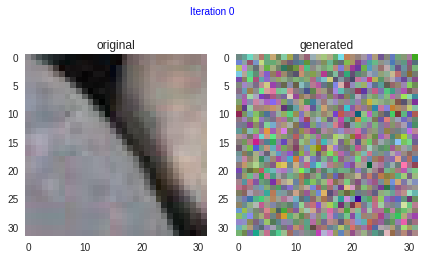

Epoch 1/20, training loss: 0.7058613300323486, validation loss: 0.6945843696594238
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 2/20, training loss: 0.051585450768470764, validation loss: 0.7018637657165527
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 3/20, training loss: 0.06670210510492325, validation loss: 0.7935958504676819
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 4/20, training loss: 0.09264522790908813, validation loss: 0.8755649924278259
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 5/20, training loss: 0.008173531852662563, validation loss: 0.9090090394020081
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 6/20, training loss: 0.0025675296783447266, validation loss: 0.8803398013114929
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 7/20, training loss: 0.0019117726478725672, validation loss: 0.8213137984275818
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 8/20, training loss: 0.0016777780838310719, validation loss: 0.771595299243927
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 9/20, training loss: 0.0014635191764682531, validation loss: 0.690570592880249
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 10/20, training loss: 0.0012211799621582031, validation loss: 0.6203868985176086
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 11/20, training loss: 0.0009316603536717594, validation loss: 0.7687740325927734
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 12/20, training loss: 0.0006505913333967328, validation loss: 1.0067740678787231
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 13/20, training loss: 0.0004305839538574219, validation loss: 1.2503801584243774
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 14/20, training loss: 0.0002824730472639203, validation loss: 1.433904767036438
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 15/20, training loss: 0.0001893573353299871, validation loss: 1.5783543586730957
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 16/20, training loss: 0.00013136863708496094, validation loss: 1.6952389478683472
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 17/20, training loss: 9.446674084756523e-05, validation loss: 1.787732720375061
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 18/20, training loss: 7.035997259663418e-05, validation loss: 1.8603750467300415
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 19/20, training loss: 5.404154580901377e-05, validation loss: 1.918411135673523
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 20/20, training loss: 4.280938082956709e-05, validation loss: 1.967990517616272
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 21/20, training loss: 3.465016561676748e-05, validation loss: 2.012443780899048
	     precision: 0.3333
	        recall: 0.5000
	            F1: 0.4000
	      accuracy: 0.6667
Synthesizing...
texture_dataset_len =  12


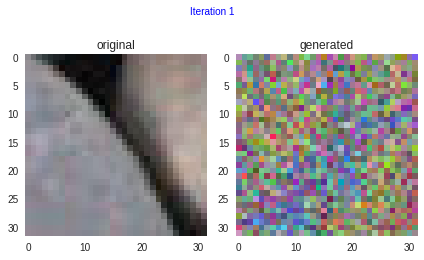

Epoch 1/20, training loss: 3.195906400680542, validation loss: 44.23629379272461
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 2/20, training loss: 0.19601678848266602, validation loss: 69.64511108398438
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 3/20, training loss: 0.034981925040483475, validation loss: 69.7898178100586
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 4/20, training loss: 0.018296249210834503, validation loss: 60.80998229980469
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 5/20, training loss: 0.011948717758059502, validation loss: 50.45685958862305
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 6/20, training loss: 0.008539239875972271, validation loss: 40.90948486328125
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 7/20, training loss: 0.006561504676938057, validation loss: 32.77909851074219
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 8/20, training loss: 0.005357477348297834, validation loss: 26.22930145263672
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 9/20, training loss: 0.004604604560881853, validation loss: 21.08545684814453
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 10/20, training loss: 0.004126535728573799, validation loss: 17.108715057373047
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 11/20, training loss: 0.0038119819946587086, validation loss: 14.048394203186035
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 12/20, training loss: 0.003595855552703142, validation loss: 11.69190502166748
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 13/20, training loss: 0.0034225385170429945, validation loss: 9.8519868850708
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 14/20, training loss: 0.003262506565079093, validation loss: 8.39928913116455
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 15/20, training loss: 0.0030978256836533546, validation loss: 7.233816146850586
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 16/20, training loss: 0.002921793144196272, validation loss: 6.287099838256836
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 17/20, training loss: 0.002733204048126936, validation loss: 5.5072150230407715
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 18/20, training loss: 0.0025360053405165672, validation loss: 4.854030132293701
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 19/20, training loss: 0.0023356543388217688, validation loss: 4.299378871917725
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 20/20, training loss: 0.0021377934608608484, validation loss: 3.8210561275482178
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 21/20, training loss: 0.001948542078025639, validation loss: 3.395284414291382
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000
Synthesizing...
NOT CONV 0.7872301340103149 50
NOT CONV 0.7608842253684998 50
NOT CONV 0.86507248878479 50
NOT CONV 0.6767807006835938 50
NOT CONV 0.8045775294303894 50
texture_dataset_len =  12


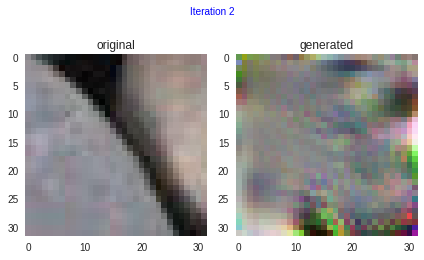

Epoch 1/20, training loss: 0.005322668235749006, validation loss: 28.42128562927246
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 2/20, training loss: 0.11002740263938904, validation loss: 0.43942615389823914
	     precision: 0.5000
	        recall: 0.3333
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 3/20, training loss: 0.0009616215829737484, validation loss: 0.0
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
NOT CONV 0.8591511845588684 50
NOT CONV 0.6416910886764526 50
NOT CONV 0.8016046285629272 50
NOT CONV 0.770807147026062 50
NOT CONV 0.8930751085281372 50
NOT CONV 0.8525416851043701 50
NOT CONV 0.8758944869041443 50
NOT CONV 0.4447317123413086 50
NOT CONV 0.8757720589637756 50
texture_dataset_len =  12


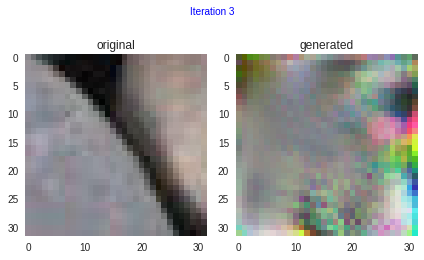

Epoch 1/20, training loss: 0.37821900844573975, validation loss: 12.60717487335205
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 2/20, training loss: 0.0034631623420864344, validation loss: 15.626675605773926
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 3/20, training loss: 0.0013575819320976734, validation loss: 14.301756858825684
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 4/20, training loss: 0.0016751554794609547, validation loss: 11.692952156066895
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 5/20, training loss: 0.0014890565071254969, validation loss: 8.98598575592041
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 6/20, training loss: 0.0010294914245605469, validation loss: 6.5923285484313965
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 7/20, training loss: 0.0006158351898193359, validation loss: 4.5822625160217285
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 8/20, training loss: 0.0003372033534105867, validation loss: 2.950403928756714
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 9/20, training loss: 0.00017425749683752656, validation loss: 1.6886295080184937
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 10/20, training loss: 8.643997716717422e-05, validation loss: 0.6814286708831787
	     precision: 0.1667
	        recall: 0.5000
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 11/20, training loss: 4.6147240936988965e-05, validation loss: 0.11095893383026123
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
NOT CONV 0.5964740514755249 50
NOT CONV 0.5884596109390259 50
NOT CONV 0.35550451278686523 50
NOT CONV 0.357129842042923 50
NOT CONV 0.3910328447818756 50
NOT CONV 0.6088142395019531 50
NOT CONV 0.3187597692012787 50
NOT CONV 0.4768403172492981 50
NOT CONV 0.4496003985404968 50
texture_dataset_len =  12


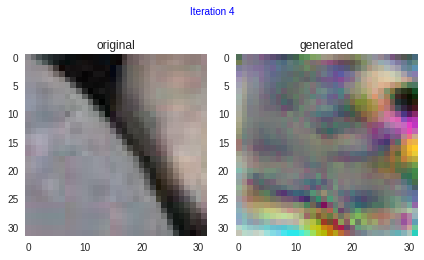

Epoch 1/20, training loss: 0.5781444311141968, validation loss: 1.1603037819440942e-05
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
NOT CONV 0.6054174304008484 50
NOT CONV 0.6538854837417603 50
NOT CONV 0.6748908758163452 50
NOT CONV 0.25447216629981995 50
NOT CONV 0.6053422689437866 50
NOT CONV 0.6081732511520386 50
NOT CONV 0.5401502251625061 50
NOT CONV 0.43427541851997375 50
NOT CONV 0.5554413795471191 50
texture_dataset_len =  12


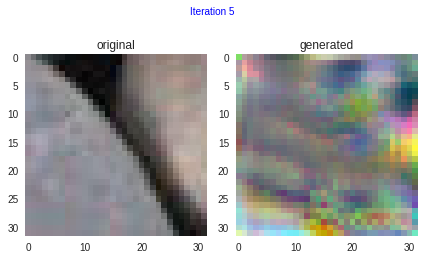

Epoch 1/20, training loss: 0.19861134886741638, validation loss: 2.4611005783081055
	     precision: 0.5000
	        recall: 0.1667
	            F1: 0.2500
	      accuracy: 0.3333


Epoch 2/20, training loss: 0.002162244636565447, validation loss: 0.001268625259399414
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
NOT CONV 0.5372070074081421 50
NOT CONV 0.4588702917098999 50
NOT CONV 0.4932946562767029 50
NOT CONV 0.39645200967788696 50
NOT CONV 0.5369781255722046 50
NOT CONV 0.3781183362007141 50
NOT CONV 0.4781588315963745 50
NOT CONV 0.5831030011177063 50
NOT CONV 0.5388914942741394 50
texture_dataset_len =  12


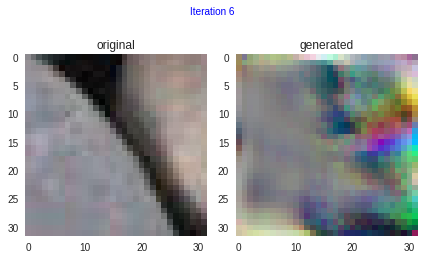

Epoch 1/20, training loss: 0.5785302519798279, validation loss: 1.1379269361495972
	     precision: 0.7500
	        recall: 0.7500
	            F1: 0.6667
	      accuracy: 0.6667


Epoch 2/20, training loss: 0.0025942325592041016, validation loss: 0.9544727206230164
	     precision: 0.7500
	        recall: 0.7500
	            F1: 0.6667
	      accuracy: 0.6667


Epoch 3/20, training loss: 0.006134801544249058, validation loss: 0.2580321729183197
	     precision: 0.7500
	        recall: 0.7500
	            F1: 0.6667
	      accuracy: 0.6667


Epoch 4/20, training loss: 0.007982333190739155, validation loss: 1.1761982932512183e-05
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
NOT CONV 0.6066746711730957 50
NOT CONV 0.6187111139297485 50
NOT CONV 0.5685107111930847 50
NOT CONV 0.5601287484169006 50
NOT CONV 0.34734585881233215 50
NOT CONV 0.6235963702201843 50
NOT CONV 0.4949783980846405 50
NOT CONV 0.5836431384086609 50
NOT CONV 0.581676185131073 50
texture_dataset_len =  12


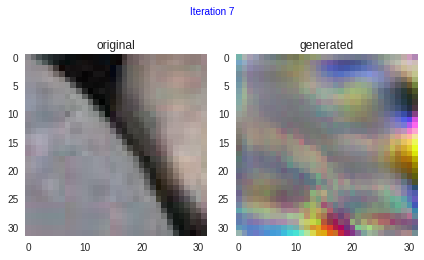

Epoch 1/20, training loss: 0.02332697995007038, validation loss: 4.035542011260986
	     precision: 0.5000
	        recall: 0.3333
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 2/20, training loss: 0.0022190676536411047, validation loss: 1.895074486732483
	     precision: 0.5000
	        recall: 0.3333
	            F1: 0.4000
	      accuracy: 0.6667


Epoch 3/20, training loss: 0.0008055104408413172, validation loss: 0.1479702591896057
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
NOT CONV 0.5253311395645142 50
NOT CONV 0.2501161992549896 50
NOT CONV 0.46815937757492065 50
NOT CONV 0.4363626539707184 50
NOT CONV 0.5904000401496887 50
NOT CONV 0.583084225654602 50


KeyboardInterrupt: ignored

In [42]:
from warnings import filterwarnings
filterwarnings('ignore')

l = 10;
tmax = 50;
freq = tmax // 2

s = Synthesis()

for t in tqdm_notebook(range(tmax)):
    
    augs = []
    print ('Synthesizing...')
    for i in range(l):
        if t == 0:
            aug = torch.empty(model.X.data.shape).data.normal_(mean, std)
        else:
            c = np.random.choice(range(1,l), 1, replace = False)[0]
            model.X.data = texture_dataset.pseudo_neg_imgs[-c].unsqueeze(0).cuda() # randomly initialize x from pos-neg dist
            aug = s.sample(model, iter_max = 50, learning_rate=0.05, add_noise=False, reinitialize = False);
         
        aug -= aug.min();
        aug /= aug.max();
        augs.append(aug)   
    
    # augmentation
    texture_dataset.pseudo_neg_imgs = []
    for aug in augs:
        texture_dataset.add_artificial(aug);
    print ('texture_dataset_len = ', len(texture_dataset))
    
    plot_samples(texture_dataset, t, l = l,  k = 1)
#     img = (deprocess(aug))
#     plt.imsave('./INN_texture_{}.jpg'.format(t), img)
    
    
#     if tmax % freq == 0:
#         torch.save(texture_dataset, './dataset_{0}_{1}.pt'.format(texture, t))
    
    test_size = int(0.3*len(texture_dataset))
    train_loader, val_loader = torch.utils.data.random_split(texture_dataset, [len(texture_dataset) - test_size, test_size ])
    
    train(model, train_loader, val_loader, epochs= 20, batch_size = 50);    

In [0]:
batch = torch.cat([tens.unsqueeze(0) for tens in texture_dataset.pseudo_neg_imgs[-100:]])
batch = batch.cuda()
answ = model.forward(batch).argmax(1)

In [54]:
y_pred = answ.detach().cpu().numpy()
y_true = np.ones_like(y_pred)
confusion_matrix(y_true, y_pred)

array([[ 0,  0],
       [52, 48]])